In [1]:
import gen as g
from tqdm import tqdm  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle
import os

In [2]:
# base function to run the character generation logic.

def generate():
    dead_farmers = 0
        
    recommended_species = None
    
    chosen_class = None
    
    background = None

    while not (recommended_species and chosen_class and background):
        stats, attempts = g.roll_stats()
        dead_farmers += attempts
        recommended_species = g.recommend_species(stats)  
        updated_stats = g.apply_species_bonus(stats, recommended_species)
        optimal_stats = g.sort_stats(updated_stats)    
        chosen_class = g.select_class(optimal_stats)    
        background = g.pick_background(optimal_stats)
    alignment = g.determine_alignment(dead_farmers)

    return recommended_species, chosen_class, background, alignment, dead_farmers
    

In [3]:
# Run the generate function a bunch of times and keep track of selections to get a distribution.

def track_species_selection(num_iterations):
    
    species_count = {}
    classes_count = {}
    background_count = {}
    alignment_count = {}
    dead_farmers_count = {}
    species_class_count = {}
    for _ in (range(num_iterations)):
        species, chosen_class, chosen_background, alignment, dead_farmers = generate()
        
        if species in species_count:
            species_count[species] += 1
        else:
            species_count[species] = 1
            
        if chosen_class in classes_count:
            classes_count[chosen_class] += 1
        else:
            classes_count[chosen_class] = 1
            
        if chosen_background in background_count:
            background_count[chosen_background] += 1
        else:
            background_count[chosen_background] = 1
            
        if alignment in alignment_count:
            alignment_count[alignment] += 1
        else:
            alignment_count[alignment] = 1
            
            
        if dead_farmers in dead_farmers_count:
            dead_farmers_count[dead_farmers] += 1
        else:
            dead_farmers_count[dead_farmers] = 1
            
            
            
            
        if species not in species_class_count:
            species_class_count[species] = {}

        if chosen_class in species_class_count[species]:
            species_class_count[species][chosen_class] += 1
        else:
            species_class_count[species][chosen_class] = 1

    return species_count, classes_count, background_count, alignment_count, dead_farmers_count, species_class_count

In [4]:
# Run the simulation at least 30 times to obtain enough data to calculate confidence intervals

def run_simulation(num_simulations, num_iterations):
    result = []
    for _ in tqdm(range(num_simulations)):
        results = (track_species_selection(num_iterations))
        result.append(results)
    return result

In [5]:
num_iterations = 1000
num_simulations = 10

In [6]:
## Run the simulation and save the results as a pickle

file_path = "sim_results.pkl"

# Check if the file exists
if not os.path.exists(file_path):
    results = run_simulation(num_simulations, num_iterations)
    with open('sim_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print('simulation done')

else:
    print('already done')
    with open('sim_results.pkl', 'rb') as f:
        results = pickle.load(f)


already done


In [7]:
### Time to parse results ###

In [8]:
def get_species_class_combo_counts(results):
    species_class_combo_counts = {}
    for i in range(num_simulations):
        for species in results[i][5]:
            for classe, count in results[i][5][species].items():
                # print(classe, count)

                if (species, classe) not in species_class_combo_counts:
                    species_class_combo_counts[(species, classe)] = []
                    species_class_combo_counts[(species, classe)].append(count)
                elif (species, classe) in species_class_combo_counts:
                    species_class_combo_counts[(species, classe)].append(count) 
                    
    return species_class_combo_counts

def get_counts(j):
    new_dict = {}
    for i in range(num_simulations):
        for item in results[i][j].items():
            # print(item[0])
            if item[0] not in new_dict:
                new_dict[item[0]] = []
                new_dict[item[0]].append(item[1])
            elif item[0] in new_dict:
                new_dict[item[0]].append(item[1])
                
    return new_dict

In [9]:
species_selection_counts = get_counts(0)
class_selection_counts = get_counts(1)
background_selection_counts = get_counts(2)
alignment_selection_counts = get_counts(3)
dead_farmer_counts = get_counts(4)
species_class_combo_counts = get_species_class_combo_counts(results)

In [10]:
def calculate_parameters(dictionary):
    means = {}
    variances = {}
    for key, value in dictionary.items():

        means[key] = np.mean(value)
        variances[key] = np.var(value)
        
    return means, variances



species_means, species_variances = calculate_parameters(species_selection_counts)
class_means, class_variances = calculate_parameters(class_selection_counts)
background_means, background_variances = calculate_parameters(background_selection_counts)
alignment_means, alignment_variances = calculate_parameters(alignment_selection_counts)
dead_farmer_means, dead_farmer_variances = calculate_parameters(dead_farmer_counts)
species_class_combo_means, species_class_combo_variances = calculate_parameters(species_class_combo_counts)

In [11]:
def calculate_CI(means, variances):
    CI_lower = {}
    CI_upper = {}
    CI = {}
    for key in means:
        CI[key] = (
            np.round(means[key] - (1.96 * (np.sqrt(variances[key]) / np.sqrt(num_simulations))), 2), 
            np.round(means[key] + (1.96 * (np.sqrt(variances[key]) / np.sqrt(num_simulations))), 2)
        )
    return CI

In [12]:
species_CI = calculate_CI(species_means, species_variances)
class_CI = calculate_CI(class_means, class_variances)
background_CI = calculate_CI(background_means, background_variances)
alignment_CI = calculate_CI(alignment_means, alignment_variances)
dead_farmer_CI = calculate_CI(dead_farmer_means, dead_farmer_variances)
species_class_CI = calculate_CI(species_class_combo_means, species_class_combo_variances)

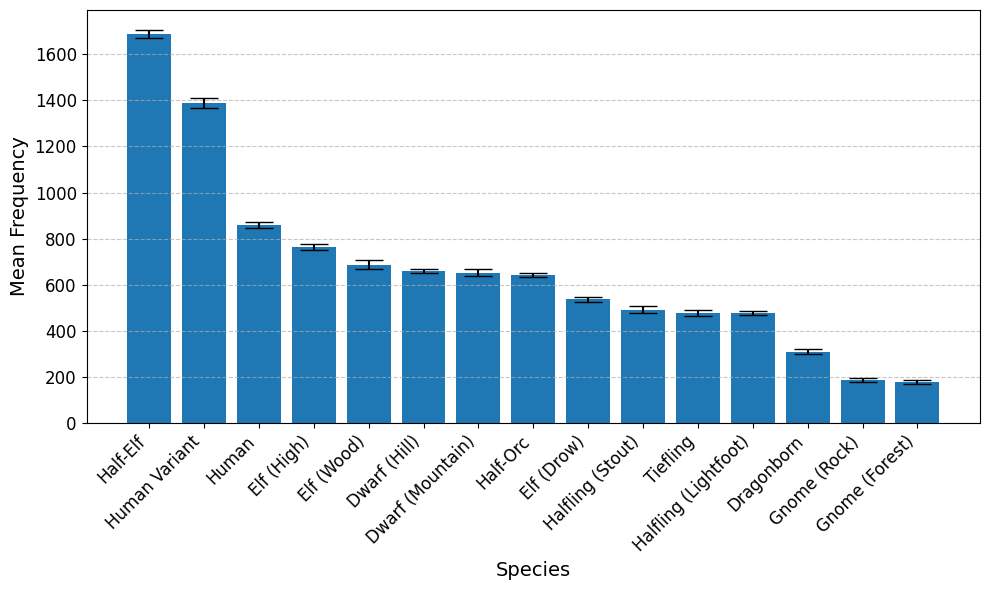

\begin{table}
\centering
\caption{Population Percentages of Adventurers}
\begin{tabular}{l r}
\toprule
             Species & Percentage of Population \\
\midrule
            Half-Elf &          [16.71, 17.07]\% \\
       Human Variant &          [13.68, 14.12]\% \\
               Human &            [8.48, 8.72]\% \\
          Elf (High) &            [7.51, 7.77]\% \\
          Elf (Wood) &             [6.7, 7.05]\% \\
        Dwarf (Hill) &            [6.51, 6.68]\% \\
    Dwarf (Mountain) &            [6.38, 6.68]\% \\
            Half-Orc &            [6.34, 6.51]\% \\
          Elf (Drow) &            [5.25, 5.48]\% \\
    Halfling (Stout) &            [4.76, 5.06]\% \\
Halfling (Lightfoot) &             [4.7, 4.87]\% \\
            Tiefling &             [4.66, 4.9]\% \\
          Dragonborn &             [2.98, 3.2]\% \\
        Gnome (Rock) &            [1.76, 1.95]\% \\
      Gnome (Forest) &            [1.68, 1.85]\% \\
\bottomrule
\end{tabular}
\end{table}



In [13]:
sorted_data = sorted(species_CI.items(), key=lambda x: (x[1][0] + x[1][1]) / 2, reverse=True)
species = [item[0] for item in sorted_data]
means = [(lower + upper) / 2 for lower, upper in [item[1] for item in sorted_data]]
ci_widths = [(upper - lower) / 2 for lower, upper in [item[1] for item in sorted_data]]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(species, means, yerr = ci_widths, capsize = 10)

# Adding labels and formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize =12)
plt.xlabel('Species', fontsize=14)
plt.ylabel('Mean Frequency', fontsize=14)
# plt.title('Species Means with Confidence Intervals (Descending Order)', fontsize=16)
# plt.ylim(min(means) - 10, max(means) + 10)  # Zoom in on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
# for bar, mean in zip(bars, means):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
#              f'{mean:.1f}\n{np.round((mean / pop) * 100, 0)}% ', ha='center', va='bottom', fontsize=10)
# / {np.round((mean / pop) * 100, 0)}%
plt.tight_layout()
plt.savefig('species_results.png')
plt.show()

pop = 10000
species_percentages = {}
for species, (lower, upper) in species_CI.items():
    lower_percent = np.round((lower / pop) * 100, 2)
    upper_percent = np.round((upper / pop) * 100, 2)
    species_percentages[species] = f'[{lower_percent}, {upper_percent}]%'

# Create a DataFrame for species percentages
df = pd.DataFrame(list(species_percentages.items()), columns=['Species', 'Percentage of Population'])

# Extract the numeric range from the percentage strings and calculate the midpoint
df[['Lower', 'Upper']] = df['Percentage of Population'].str.extract(r'\[(\d+\.\d+),\s*(\d+\.\d+)\]').astype(float)
df['Midpoint'] = (df['Lower'] + df['Upper']) / 2

# Sort the DataFrame based on the midpoint of the percentage range
df = df.sort_values(by='Midpoint', ascending=False).drop(columns=['Lower', 'Upper', 'Midpoint'])

# Generate the LaTeX table
latex_table = df.to_latex(index=False, column_format='l r', float_format='%.2f', caption='Population Percentages of Adventurers')
print(latex_table)


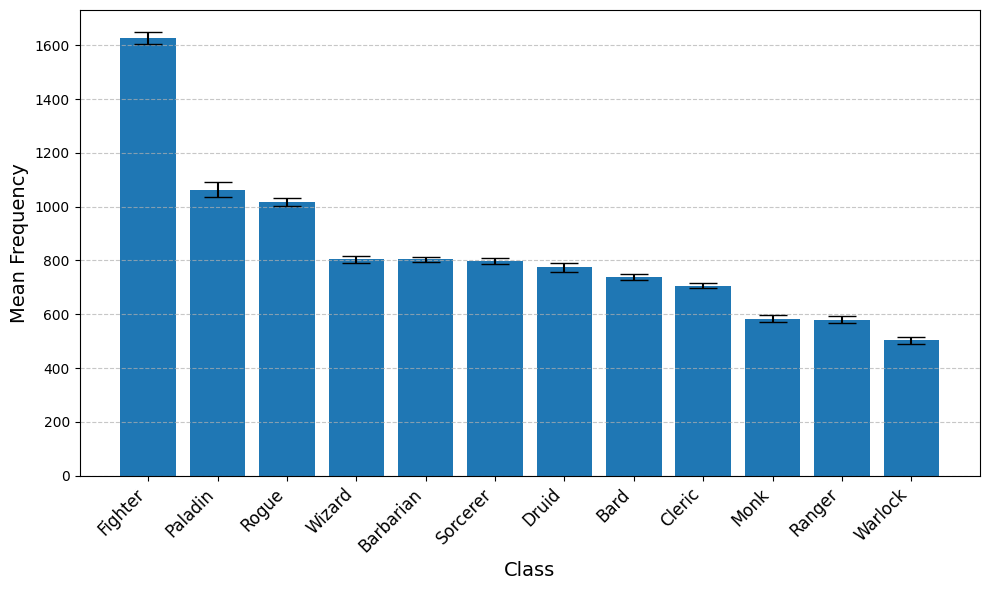

\begin{table}
\centering
\caption{Population Percentages of Adventurers}
\begin{tabular}{l r}
\toprule
  Species & Percentage of Population \\
\midrule
  Fighter &          [16.03, 16.49]\% \\
  Paladin &          [10.35, 10.92]\% \\
    Rogue &          [10.01, 10.33]\% \\
   Wizard &            [7.92, 8.17]\% \\
Barbarian &            [7.94, 8.14]\% \\
 Sorcerer &             [7.88, 8.1]\% \\
    Druid &            [7.58, 7.91]\% \\
     Bard &            [7.27, 7.48]\% \\
   Cleric &            [6.96, 7.16]\% \\
     Monk &             [5.7, 5.96]\% \\
   Ranger &            [5.68, 5.93]\% \\
  Warlock &            [4.91, 5.17]\% \\
\bottomrule
\end{tabular}
\end{table}



In [14]:


sorted_data = sorted(class_CI.items(), key=lambda x: (x[1][0] + x[1][1]) / 2, reverse=True)
species = [item[0] for item in sorted_data]
means = [(lower + upper) / 2 for lower, upper in [item[1] for item in sorted_data]]
ci_widths = [(upper - lower) / 2 for lower, upper in [item[1] for item in sorted_data]]

# Plotting the bar plot
plt.figure(figsize=(10,6))
bars = plt.bar(species, means, yerr = ci_widths, capsize = 10)

# Adding labels and formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Mean Frequency', fontsize=14)
# plt.title('Species Means with Confidence Intervals (Descending Order)', fontsize=16)
# plt.ylim(min(means) - 10, max(means) + 10)  # Zoom in on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
# for bar, mean in zip(bars, means):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
#              f'{mean:.1f}\n{np.round((mean / pop) * 100, 0)}% ', ha='center', va='bottom', fontsize=10)
# / {np.round((mean / pop) * 100, 0)}%
plt.tight_layout()
plt.savefig('class_results.png')
plt.show()

pop = 10000

class_percentages = {}
for class_, (lower, upper) in class_CI.items():
    lower_percent = np.round((lower / pop) * 100, 2)
    upper_percent = np.round((upper / pop) * 100, 2)
    class_percentages[class_] = f'[{lower_percent}, {upper_percent}]%'

# Create a DataFrame for species percentages
df = pd.DataFrame(list(class_percentages.items()), columns=['Species', 'Percentage of Population'])

# Extract the numeric range from the percentage strings and calculate the midpoint
df[['Lower', 'Upper']] = df['Percentage of Population'].str.extract(r'\[(\d+\.\d+),\s*(\d+\.\d+)\]').astype(float)
df['Midpoint'] = (df['Lower'] + df['Upper']) / 2

# Sort the DataFrame based on the midpoint of the percentage range
df = df.sort_values(by='Midpoint', ascending=False).drop(columns=['Lower', 'Upper', 'Midpoint'])

# Generate the LaTeX table
latex_table = df.to_latex(index=False, column_format='l r', float_format='%.2f', caption='Population Percentages of Adventurers')
print(latex_table)

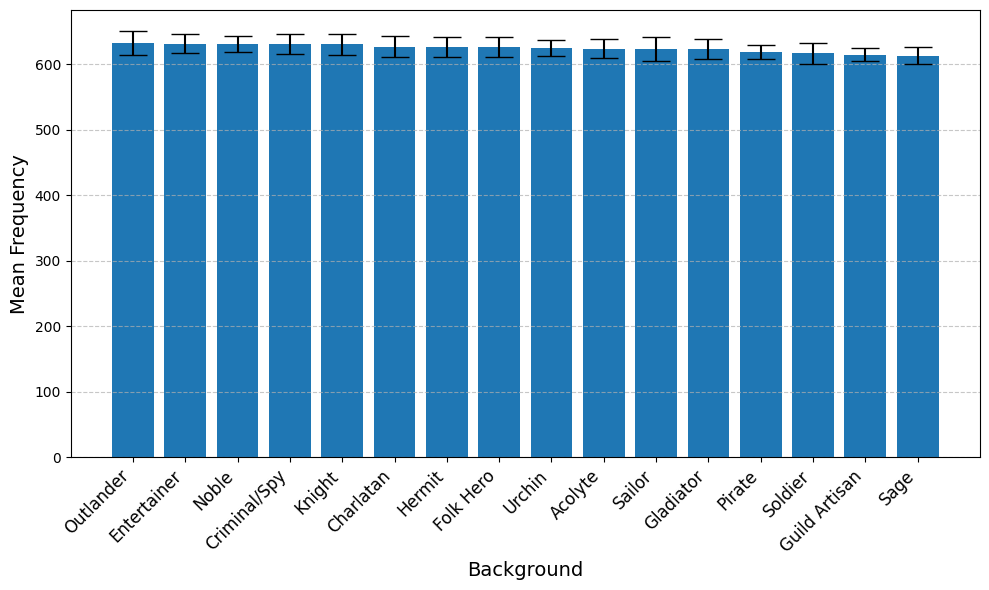

\begin{table}
\centering
\caption{Population Percentages of Adventurers}
\begin{tabular}{l r}
\toprule
      Species & Percentage of Population \\
\midrule
    Outlander &            [6.14, 6.51]\% \\
        Noble &             [6.2, 6.44]\% \\
  Entertainer &            [6.17, 6.46]\% \\
       Knight &            [6.15, 6.47]\% \\
 Criminal/Spy &            [6.16, 6.46]\% \\
       Hermit &            [6.12, 6.43]\% \\
    Folk Hero &            [6.12, 6.42]\% \\
    Charlatan &            [6.11, 6.43]\% \\
       Urchin &            [6.13, 6.37]\% \\
      Acolyte &            [6.09, 6.39]\% \\
    Gladiator &            [6.09, 6.39]\% \\
       Sailor &            [6.05, 6.42]\% \\
       Pirate &             [6.09, 6.3]\% \\
      Soldier &             [6.0, 6.34]\% \\
Guild Artisan &            [6.05, 6.25]\% \\
         Sage &            [6.01, 6.26]\% \\
\bottomrule
\end{tabular}
\end{table}



In [15]:
sorted_data = sorted(background_CI.items(), key=lambda x: (x[1][0] + x[1][1]) / 2, reverse=True)
background = [item[0] for item in sorted_data]
means = [(lower + upper) / 2 for lower, upper in [item[1] for item in sorted_data]]
ci_widths = [(upper - lower) / 2 for lower, upper in [item[1] for item in sorted_data]]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(background, means, yerr = ci_widths, capsize = 10)

# Adding labels and formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Background', fontsize=14)
plt.ylabel('Mean Frequency', fontsize=14)
# plt.title('Species Means with Confidence Intervals (Descending Order)', fontsize=16)
# plt.ylim(min(means) - 10, max(means) + 10)  # Zoom in on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
# for bar, mean in zip(bars, means):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
#              f'{mean:.1f}\n{np.round((mean / pop) * 100, 0)}% ', ha='center', va='bottom', fontsize=10)
# / {np.round((mean / pop) * 100, 0)}%
plt.tight_layout()
plt.savefig('background_results.png')
plt.show()

pop = 10000

pop = 10000
background_percentages = {}
for background, (lower, upper) in background_CI.items():
    lower_percent = np.round((lower / pop) * 100, 2)
    upper_percent = np.round((upper / pop) * 100, 2)
    background_percentages[background] = f'[{lower_percent}, {upper_percent}]%'

# Create a DataFrame for species percentages
df = pd.DataFrame(list(background_percentages.items()), columns=['Species', 'Percentage of Population'])

# Extract the numeric range from the percentage strings and calculate the midpoint
df[['Lower', 'Upper']] = df['Percentage of Population'].str.extract(r'\[(\d+\.\d+),\s*(\d+\.\d+)\]').astype(float)
df['Midpoint'] = (df['Lower'] + df['Upper']) / 2

# Sort the DataFrame based on the midpoint of the percentage range
df = df.sort_values(by='Midpoint', ascending=False).drop(columns=['Lower', 'Upper', 'Midpoint'])

# Generate the LaTeX table
latex_table = df.to_latex(index=False, column_format='l r', float_format='%.2f', caption='Population Percentages of Adventurers')
print(latex_table)

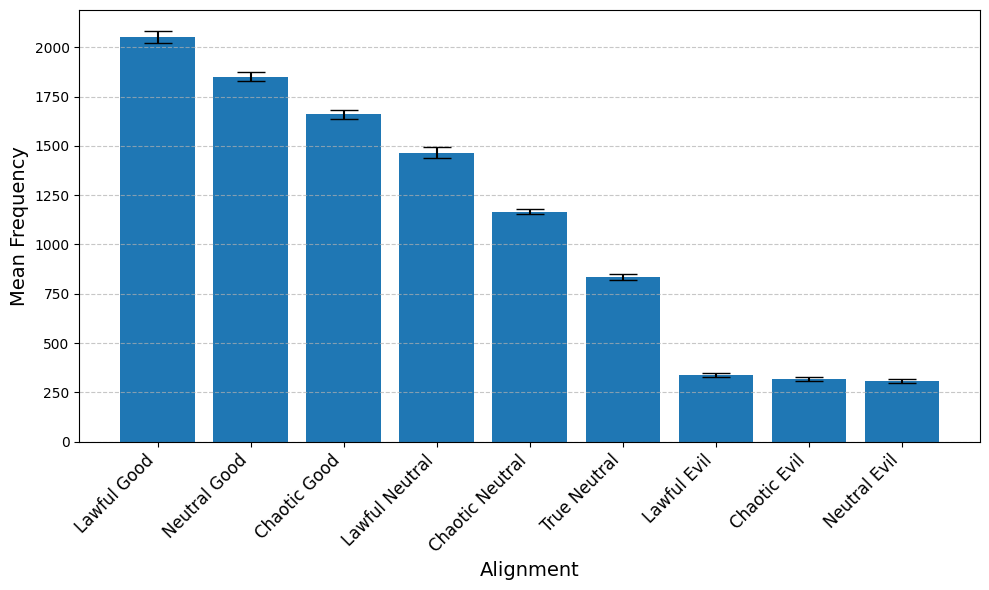

\begin{table}
\centering
\caption{Population Percentages of Adventurers}
\begin{tabular}{l r}
\toprule
        Species & Percentage of Population \\
\midrule
    Lawful Good &          [20.21, 20.85]\% \\
   Neutral Good &          [18.27, 18.75]\% \\
   Chaotic Good &          [16.38, 16.84]\% \\
 Lawful Neutral &          [14.39, 14.94]\% \\
Chaotic Neutral &          [11.54, 11.78]\% \\
   True Neutral &            [8.22, 8.49]\% \\
    Lawful Evil &             [3.3, 3.49]\% \\
   Chaotic Evil &             [3.08, 3.3]\% \\
   Neutral Evil &            [2.99, 3.17]\% \\
\bottomrule
\end{tabular}
\end{table}



In [16]:
sorted_data = sorted(alignment_CI.items(), key=lambda x: (x[1][0] + x[1][1]) / 2, reverse=True)
alignment = [item[0] for item in sorted_data]
means = [(lower + upper) / 2 for lower, upper in [item[1] for item in sorted_data]]
ci_widths = [(upper - lower) / 2 for lower, upper in [item[1] for item in sorted_data]]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(alignment, means, yerr = ci_widths, capsize = 10)

# Adding labels and formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Alignment', fontsize=14)
plt.ylabel('Mean Frequency', fontsize=14)
# plt.title('Species Means with Confidence Intervals (Descending Order)', fontsize=16)
# plt.ylim(min(means) - 10, max(means) + 10)  # Zoom in on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
# for bar, mean in zip(bars, means):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
#              f'{mean:.1f}\n{np.round((mean / pop) * 100, 0)}% ', ha='center', va='bottom', fontsize=10)
# / {np.round((mean / pop) * 100, 0)}%
plt.tight_layout()
plt.savefig('alignment_results.png')
plt.show()

pop = 10000
alignment_percentages = {}
for alignment, (lower, upper) in alignment_CI.items():
    lower_percent = np.round((lower / pop) * 100, 2)
    upper_percent = np.round((upper / pop) * 100, 2)
    alignment_percentages[alignment] = f'[{lower_percent}, {upper_percent}]%'

# Create a DataFrame for species percentages
df = pd.DataFrame(list(alignment_percentages.items()), columns=['Species', 'Percentage of Population'])

# Extract the numeric range from the percentage strings and calculate the midpoint
df[['Lower', 'Upper']] = df['Percentage of Population'].str.extract(r'\[(\d+\.\d+),\s*(\d+\.\d+)\]').astype(float)
df['Midpoint'] = (df['Lower'] + df['Upper']) / 2

# Sort the DataFrame based on the midpoint of the percentage range
df = df.sort_values(by='Midpoint', ascending=False).drop(columns=['Lower', 'Upper', 'Midpoint'])

# Generate the LaTeX table
latex_table = df.to_latex(index=False, column_format='l r', float_format='%.2f', caption='Population Percentages of Adventurers')
print(latex_table)

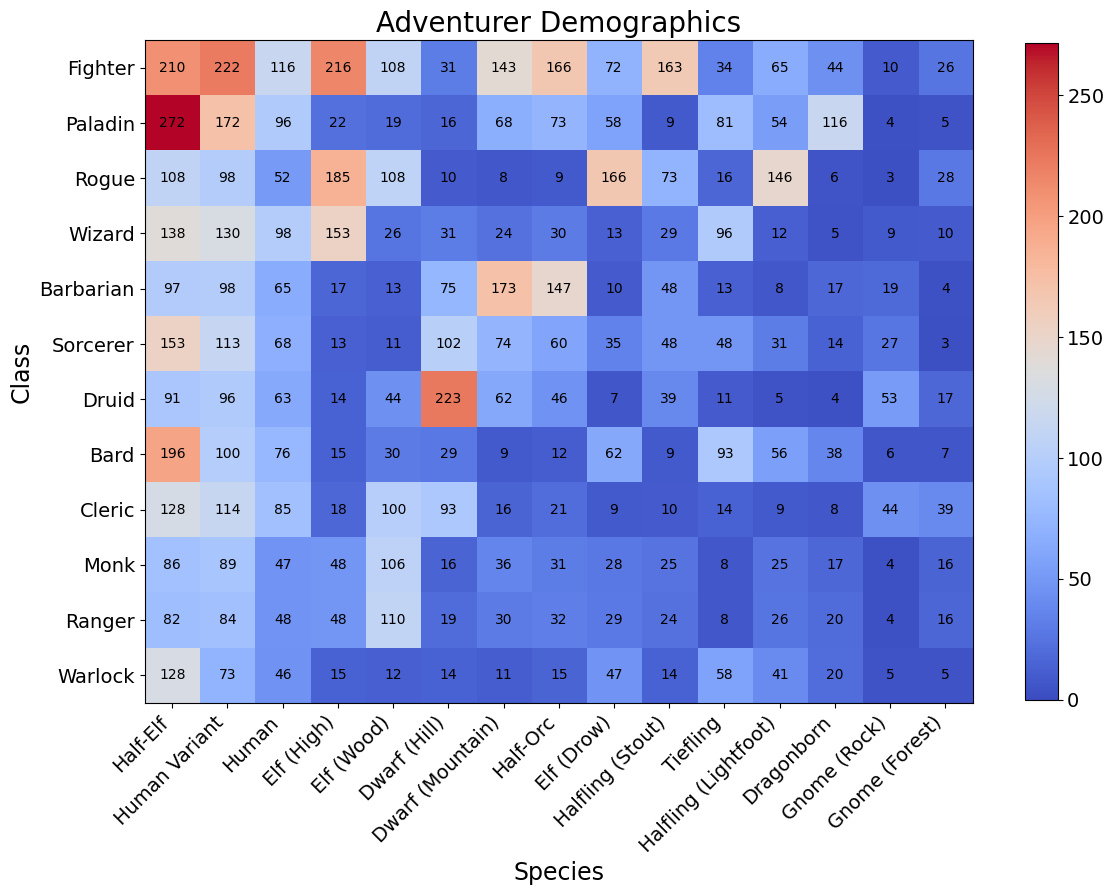

In [17]:
species = []
class_ = []
mean = []
ci_width = []

for (s, c), (lower, upper) in species_class_CI.items():
    species.append(s)
    class_.append(c)
    mean.append((upper + lower) / 2)
    ci_width.append(upper - lower)

df = pd.DataFrame({
    'Species': species,
    'Class': class_,
    'Mean': mean,
    'CI': ci_width
})




contingency_table = df.pivot(index='Class', columns='Species', values='Mean').fillna(0)

# Sort the rows (species) and columns (classes) based on their sum
species_order = contingency_table.sum(axis=1).sort_values(ascending=False).index
class_order = contingency_table.sum(axis=0).sort_values(ascending=False).index

# Reorder the contingency table
contingency_table_sorted = contingency_table.loc[species_order, class_order]

# Perform the Chi-Square Test of Independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_sorted)

# Calculate the standardized residuals
observed = contingency_table_sorted.values
residuals = (observed - expected) / np.sqrt(expected)

# Plotting the heatmap of observed means (sorted)
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(contingency_table_sorted, cmap='coolwarm', vmin=0, vmax=np.max(contingency_table_sorted.values))

# Add color bar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink = 0.75)
# cbar.set_label( '', fontsize=14)  
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(14)  # Set the font size for the ticks

# Set ticks and labels
ax.set_xticks(np.arange(len(contingency_table_sorted.columns)))
ax.set_yticks(np.arange(len(contingency_table_sorted.index)))
ax.set_xticklabels(contingency_table_sorted.columns, rotation=45, ha='right', fontsize = 14)
ax.set_yticklabels(contingency_table_sorted.index, fontsize = 14)
ax.set_title('Adventurer Demographics', fontsize = 20)
plt.ylabel('Class', fontsize = 17)
plt.xlabel('Species', fontsize = 17)

# Annotate each cell with the value
for i in range(len(contingency_table_sorted.index)):
    for j in range(len(contingency_table_sorted.columns)):
        value = contingency_table_sorted.iloc[i, j]
        ax.text(j, i, f'{value:.0f}', ha='center', va='center', color='black')
plt.savefig('species_class_combo.png')
plt.tight_layout()
plt.show()

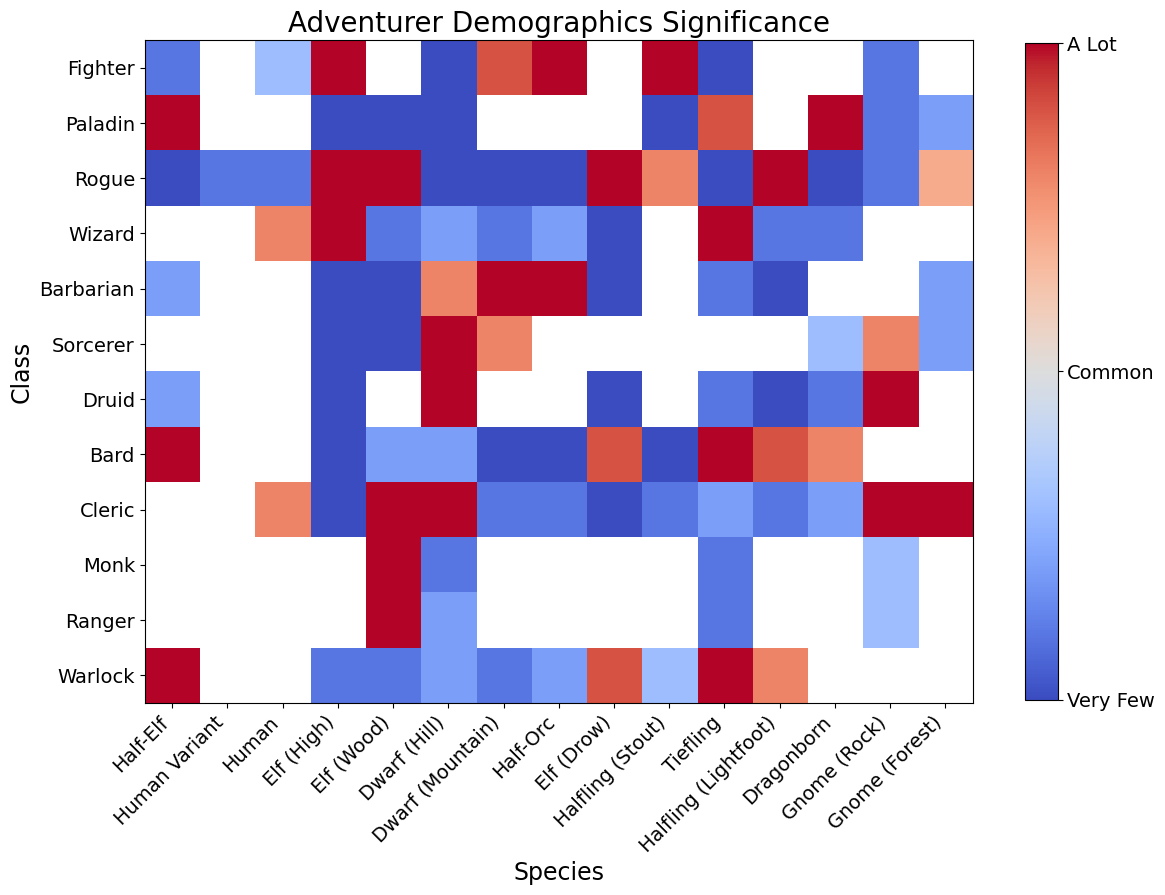

In [18]:

contingency_table = df.pivot(index='Class', columns='Species', values='Mean').fillna(0)
species_order = contingency_table.sum(axis=1).sort_values(ascending=False).index
class_order = contingency_table.sum(axis=0).sort_values(ascending=False).index

# Reorder the contingency table
contingency_table_sorted = contingency_table.loc[species_order, class_order]
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_sorted)

observed = contingency_table_sorted.values

residuals = (observed - expected) / np.sqrt(expected)

residuals_df = pd.DataFrame(residuals, index=contingency_table_sorted.index, columns=contingency_table_sorted.columns)

significant_residuals = residuals_df[(residuals_df > 2) | (residuals_df < -2)]
significant_residuals = np.round(significant_residuals, 0)
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(significant_residuals, cmap='coolwarm', vmin=-5, vmax=5)

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink = 0.75)
cbar.set_ticks([-5,0, 5])  # Set only the min and max ticks
cbar.set_ticklabels(['Very Few', 'Common', 'A Lot'])  # Set custom labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(14)  # Set the font size for the ticks
ax.set_xticks(np.arange(len(significant_residuals.columns)))
ax.set_yticks(np.arange(len(significant_residuals.index)))
ax.set_xticklabels(significant_residuals.columns, fontsize = 14)
ax.set_yticklabels(significant_residuals.index, fontsize = 14)
plt.ylabel('Class', fontsize = 17)
plt.xlabel('Species', fontsize = 17)
ax.set_title('Adventurer Demographics Significance', fontsize = 20)

plt.xticks(rotation=45, ha='right')

# for i in range(len(significant_residuals.index)):
#     for j in range(len(significant_residuals.columns)):
#         value = significant_residuals.iloc[i, j]
#         if not np.isnan(value):
#             ax.text(j, i, f'{value:.0f}', ha='center', va='center', color='black')
plt.savefig('chisq-resid.png')
plt.tight_layout()
plt.show()